# Lane Change Optimal Control using CVXPY  
This notebook computes an optimal lateral trajectory for a lane-change maneuver using:

- Double-integrator dynamics  
- Acceleration, jerk, and velocity constraints  
- Slack variables with penalties  
- Obstacle avoidance (time-window)  
- KKT dual-value inspection for one constraint  


In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
# Helper function for clean interactive inputs (optional)
def get_input(prompt, default, cast=float, validator=None):
    while True:
        s = input(f"{prompt} [{default}]: ").strip()
        if s == "":
            return default
        try:
            val = cast(s)
            if validator is None or validator(val):
                return val
            print("Validation failed. Try again.")
        except:
            print("Invalid input. Try again.")


## Interactive Parameter Inputs  
Provide values or press Enter to keep defaults.


In [3]:
dt = get_input("dt (s)", 0.1, float, lambda v: v > 0)
N = get_input("N (steps, integer >=1)", 50, int, lambda v: v >= 1)

init_y = get_input("init_y (m)", 0.0, float)
init_vy = get_input("init_vy (m/s)", 0.0, float)
target_y = get_input("target_y (m)", 3.5, float)
final_vy_target = get_input("final_vy_target (m/s)", 0.0, float)

u_max = get_input("u_max (m/s^2)", 3.0, float, lambda v: v >= 0)
v_max = get_input("v_max (m/s)", 2.0, float, lambda v: v >= 0)
jerk_max = get_input("jerk_max (m/s^3)", 2.0, float, lambda v: v >= 0)

penalty_slack = get_input("penalty_slack", 1e6, float, lambda v: v > 0)

plot_result = input("plot_result (y/n) [y]: ").strip().lower()
if plot_result == "":
    plot_result = "y"

# New obstacle input
obs_t_start = get_input("Obstacle start time (s)", 2.5, float, lambda v: v >= 0)
obs_t_end   = get_input("Obstacle end time (s)", 4.5, float, lambda v: v > obs_t_start)

## Build the Optimization Model  
We construct:
- Dynamics: `x(k+1) = A x(k) + B u(k)`  
- Constraints on:  
  - Acceleration  
  - Velocity  
  - Jerk  
  - Slack variables  
- Obstacle constraints between 2.5s and 4.5s  
- Objective: Minimize effort + slack penalties


In [4]:
dt = get_input("dt (s)", 0.1, float, lambda v: v > 0)
N = get_input("N (steps, integer >=1)", 50, int, lambda v: v >= 1)

init_y = get_input("init_y (m)", 0.0, float)
init_vy = get_input("init_vy (m/s)", 0.0, float)
target_y = get_input("target_y (m)", 3.5, float)
final_vy_target = get_input("final_vy_target (m/s)", 0.0, float)

u_max = get_input("u_max (m/s^2)", 3.0, float, lambda v: v >= 0)
v_max = get_input("v_max (m/s)", 2.0, float, lambda v: v >= 0)
jerk_max = get_input("jerk_max (m/s^3)", 2.0, float, lambda v: v >= 0)

penalty_slack = get_input("penalty_slack", 1e6, float, lambda v: v > 0)

plot_result = input("plot_result (y/n) [y]: ").strip().lower()
if plot_result == "":
    plot_result = "y"

# New obstacle inputs
obs_t_start = get_input("Obstacle start time (s)", 2.5, float, lambda v: v >= 0)
obs_t_end   = get_input("Obstacle end time (s)", 4.5, float, lambda v: v > obs_t_start)


## Build the Optimization Model  
We create:
- Dynamics `x(k+1) = A x(k) + B u(k)`
- Constraints on acceleration, jerk, velocity  
- Obstacle window constraint  
- Slack variables  
- Stored `|u| <= limit` constraints for KKT checking  


In [5]:
# Dynamics matrices
A = np.array([[1.0, dt],
              [0.0, 1.0]])

B = np.array([[0.5 * dt * dt],
              [dt]])

# Decision variables
u = cp.Variable((N, 1))
x = cp.Variable((2, N+1))

slack_u = cp.Variable((N, 1))
slack_v = cp.Variable((N+1, 1))
slack_final = cp.Variable((1, 1))

constraints = [x[:, 0] == np.array([init_y, init_vy], dtype=float)]
cost = 0

# Store acceleration constraints for KKT analysis
kkt_constraint = []

for k in range(N):
    # dynamics
    constraints += [x[:, k+1] == A @ x[:, k] + B[:, 0] * u[k, 0]]

    # acceleration limit
    c_u = (cp.abs(u[k, 0]) <= u_max + slack_u[k, 0])
    constraints += [c_u]
    kkt_constraint.append(c_u)

    # jerk constraint
    if k > 0:
        constraints += [cp.abs(u[k, 0] - u[k-1, 0]) <= jerk_max]

    cost += cp.sum_squares(u[k, 0])

# velocity limit
for k in range(N+1):
    constraints += [cp.abs(x[1, k]) <= v_max + slack_v[k, 0]]

# final state constraints
constraints += [
    x[1, N] == final_vy_target,
    x[0, N] == target_y + slack_final[0, 0],
    slack_u >= 0,
    slack_v >= 0,
    slack_final >= 0
]

# slack penalties
cost += penalty_slack * (
    cp.sum_squares(slack_u)
    + cp.sum_squares(slack_v)
    + cp.sum_squares(slack_final)
)

# obstacle time → indices
k_obs_start = int(obs_t_start / dt)
k_obs_end   = int(obs_t_end / dt)

k_obs_start = max(0, min(N-1, k_obs_start))
k_obs_end   = max(k_obs_start + 1, min(N, k_obs_end))

# obstacle constraint
for k in range(k_obs_start, k_obs_end):
    constraints += [x[0, k] >= target_y]


In [6]:
prob = cp.Problem(cp.Minimize(cost), constraints)
result = prob.solve(solver=cp.OSQP, verbose=False)
print("Solve status:", prob.status)

Solve status: optimal


In [7]:
# KKT / complementary slackness check
if prob.status in ["optimal", "optimal_inaccurate"]:
    k_check = 5
    if k_check < len(kkt_constraint):
        c = kkt_constraint[k_check]

        dual = float(c.dual_value)
        primal_gap = float(c.violation())
        comp = dual * primal_gap

        print("\n===== KKT CHECK (k = {}) =====".format(k_check))
        print(f"Constraint: |u[{k_check}]| <= u_max + slack")
        print(f"Primal gap = {primal_gap}")
        print(f"Dual value = {dual}")
        print(f"Complementary Slackness = {comp}")
        print("================================\n")
    else:
        print("k_check out of range.")
else:
    print("Skipping KKT check; problem not optimal.")



===== KKT CHECK (k = 5) =====
Constraint: |u[5]| <= u_max + slack
Primal gap = 0.0
Dual value = 0.0
Complementary Slackness = 0.0



## Plot the Results  
We show:
- Lateral position vs time  
- Obstacle window  
- Control input profile  


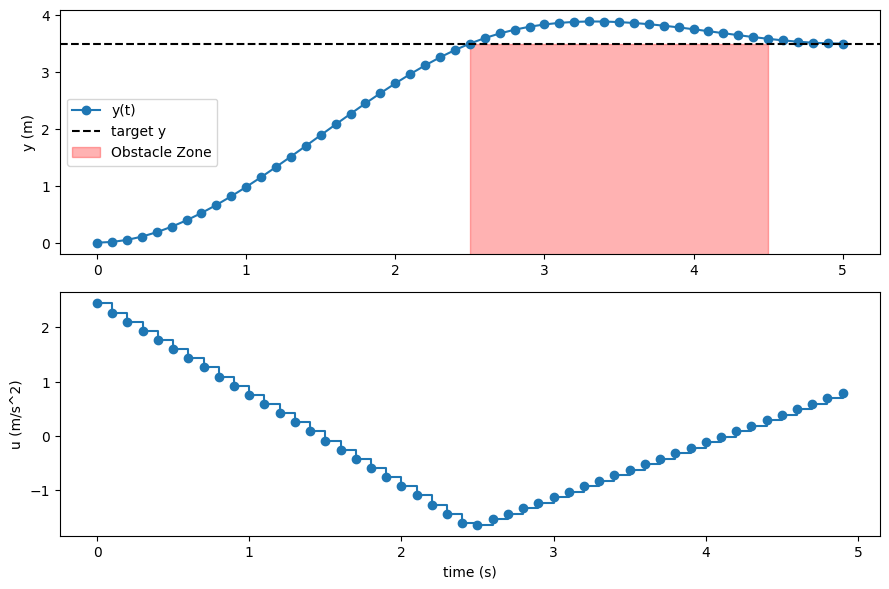

In [8]:
if prob.status in ["optimal", "optimal_inaccurate"]:
    x_np = np.array(x.value)
    u_np = np.array(u.value).reshape(-1)
    t = np.arange(N+1) * dt

    if plot_result.startswith('y'):
        fig, axs = plt.subplots(2, 1, figsize=(9, 6))

        # lateral position
        axs[0].plot(t, x_np[0, :], marker='o', label='y(t)')
        axs[0].axhline(target_y, linestyle='--', color='k', label='target y')

        # obstacle rectangle
        rect = patches.Rectangle(
            (k_obs_start * dt, -10),
            (k_obs_end - k_obs_start) * dt,
            target_y + 10,
            color='red', alpha=0.3, label='Obstacle Zone'
        )
        axs[0].add_patch(rect)

        axs[0].set_ylabel("y (m)")
        axs[0].legend()

        # control input
        axs[1].step(np.arange(N) * dt, u_np, where='post', marker='o')
        axs[1].set_xlabel("time (s)")
        axs[1].set_ylabel("u (m/s^2)")

        plt.tight_layout()
        plt.show()
    else:
        print("Plot suppressed.")
else:
    print("Optimization failed or infeasible.")
